

---


Experiment with different variants of GANs using spectral normalization


---



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import Image as DisplayImage
from PIL import Image as PILImage
import torch.nn as nn
import torch.nn.functional as F
from fastai.vision import *
from fastai.vision.gan import *

You should set the following option to True if the notebook isn't located in the file system inside a clone of the git repo (with the needed Python modules available) it belongs to; i.e., it's running independently.

In [0]:
run_as_standalone_nb = True

In [4]:
# This cell needs to be executed before importing local project modules, like import genlab.core.gan
if run_as_standalone_nb:
    root_lib_path = os.path.abspath('generative-lab')
    if not os.path.exists(root_lib_path):
        !git clone https://github.com/davidleonfdez/generative-lab.git
    if root_lib_path not in sys.path:
        sys.path.insert(0, root_lib_path)
else:
    import local_lib_import

Cloning into 'generative-lab'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 503 (delta 1), reused 6 (delta 1), pack-reused 492
Receiving objects: 100% (503/503), 407.30 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Checking out files: 100% (51/51), done.


In [0]:
# Local project modules. Must be imported after local_lib_import or cloning git repo.
from genlab.core.gan import (CustomGANLearner, GANLossArgs, gan_loss_from_func_std, GeneratorFuncStateLoader,
                      GenImagesSampler, load_gan_generator, load_gan_learner, save_gan_learner)
from genlab.core.gan_display import display_gan_out_tensor
from genlab.core.gan_metrics import evaluate_models_fid, EvaluationItem, FIDCalculator
from genlab.core.gen_utils import PrinterProgressTracker
from genlab.core.losses import hinge_adversarial_losses, hinge_like_adversarial_losses
from genlab.core.nb_utils import output_file_link
from genlab.core.net_builders import custom_critic

In [0]:
# Point this variable to the path where you want to save your models
models_root = './'

In [0]:
img_size = 64
img_n_channels = 3
batch_size = 128
use_cuda = torch.cuda.is_available()

# DATA

In Kaggle, you can easily add the CelebA dataset. For other environments, you probably need to manually download the dataset from https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8

In [0]:
real_images_path = Path('/kaggle/input/celeba-dataset/img_align_celeba/')
real_images_path

PosixPath('/kaggle/input/celeba-dataset/img_align_celeba')

In [0]:
sample_img_path = next(real_images_path.glob('**/*.jpg'))
sample_img_path

In [0]:
im = PILImage.open(sample_img_path)
im.size

In [0]:
DisplayImage(filename=str(sample_img_path))

In [0]:
def get_data(path, bs, size, noise_sz=100):
    return (GANItemList.from_folder(path, noise_sz=noise_sz)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=0.5, col_pct=0.5)], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

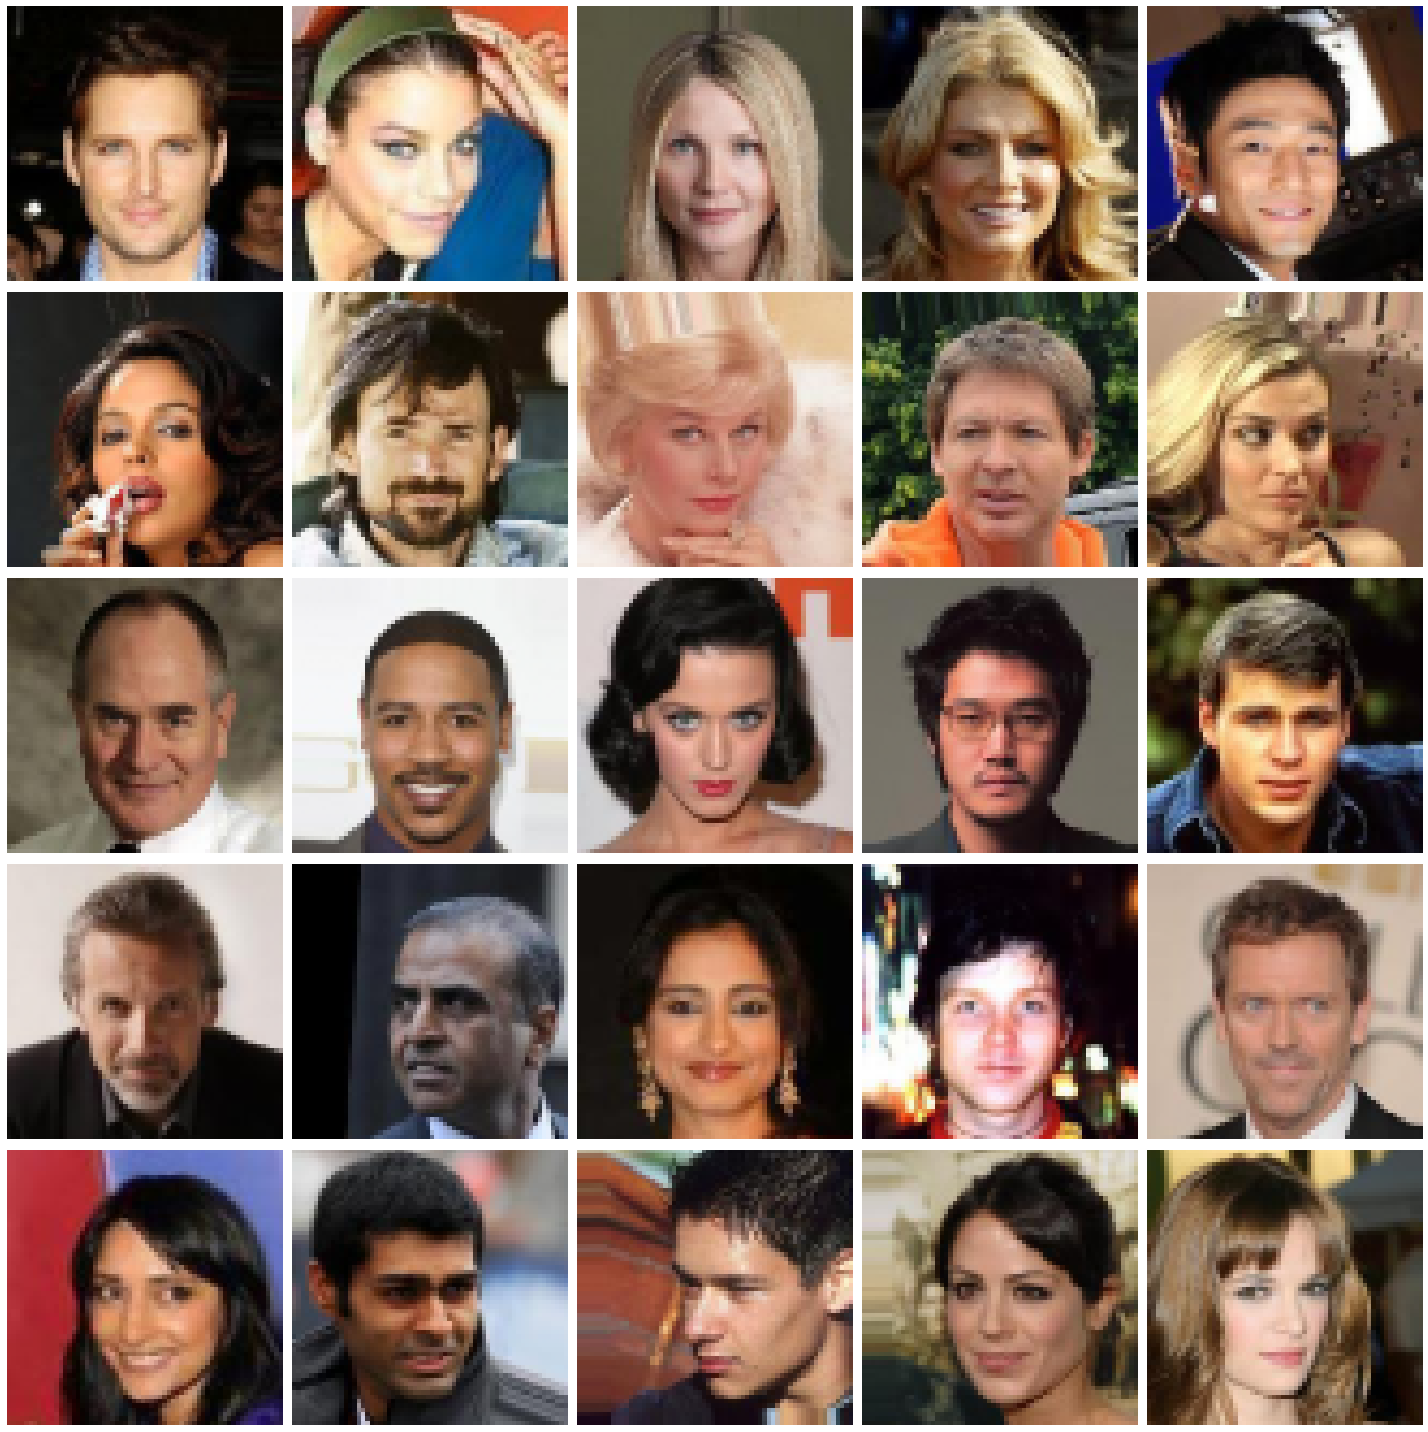

In [0]:
data = get_data(real_images_path, batch_size, img_size)
data.show_batch()

In [0]:
data

# CRITIC

```
custom_critic(in_size:int, n_channels:int, n_features:int=64, 
              n_extra_layers:int=0, self_attention:bool=False, 
              **conv_kwargs) -> nn.Module
```

In [0]:
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)

# GENERATOR

```
basic_generator(in_size:int, n_channels:int, noise_sz:int=100,  
                n_features:int=64, n_extra_layers=0, **conv_kwargs)
```

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)

# TRAINING

* The parameters of a trained model can be saved with `save_gan_learner`.
* A training run can be resumed (using weights saved during a previous session) with `load_gan_learner`. For example:
        load_gan_learner(learner, models_root + 'sngan-dcgan-Tr1a_60ep.pth')
    This must be executed after instantiating the learner and BEFORE running `learner.fit()`.

* Another alternative to launch a long training run is the method `save_checkpoint_gan`. It will automatically save the weights every `n_epochs_save_split` epochs.

## DCGAN (standard GAN with NSGAN loss function)

In [0]:
def gen_loss_func(*args): return 0
crit_loss_func = nn.BCEWithLogitsLoss()

losses = gan_loss_from_func_std(gen_loss_func, crit_loss_func)

### TR 1: Spectral norm only in critic, batch norm in generator

#### TR 1a: lr=2e-4

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1a_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1a_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1a_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1a_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

This way we can show results in a session other than when we ran learner.fit():

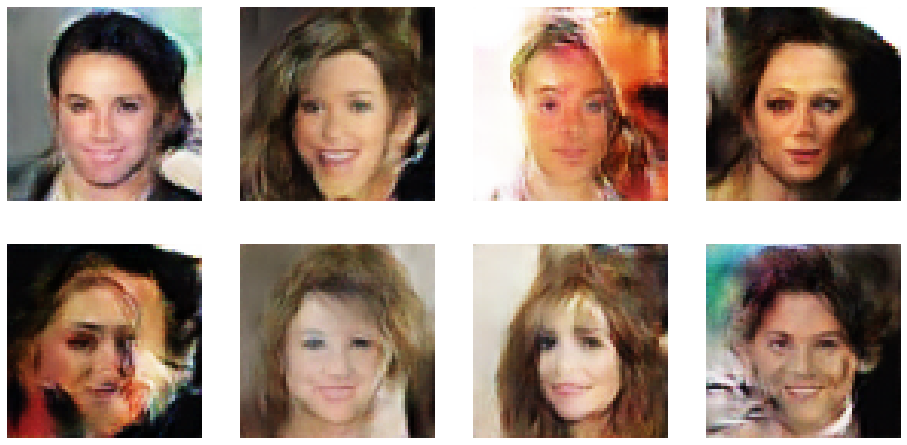

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1a_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1b: lr=5e-4

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1b_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1b_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1b_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1b_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

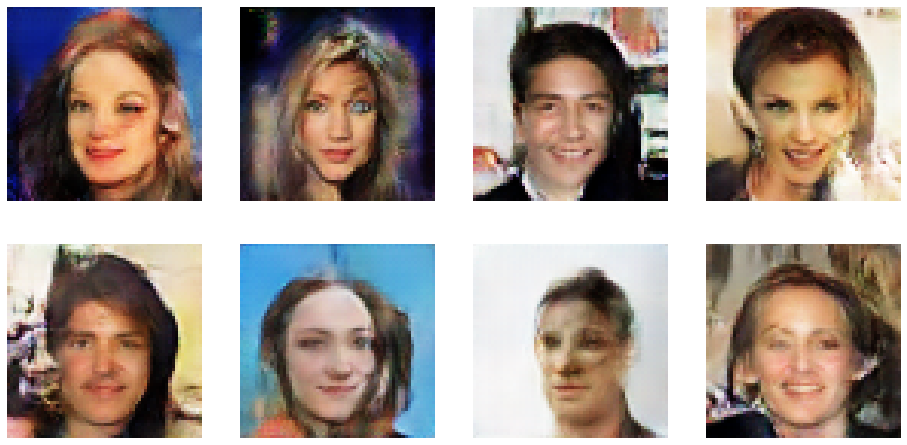

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1b_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1c: lr=2e-4, betas=(0.5,0.9)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.5,0.9)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1c_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1c_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1c_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

#### TR 1d: lr=2e-4, betas=(0.5,0.999)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.5,0.999)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1d_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1d_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1d_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1d_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

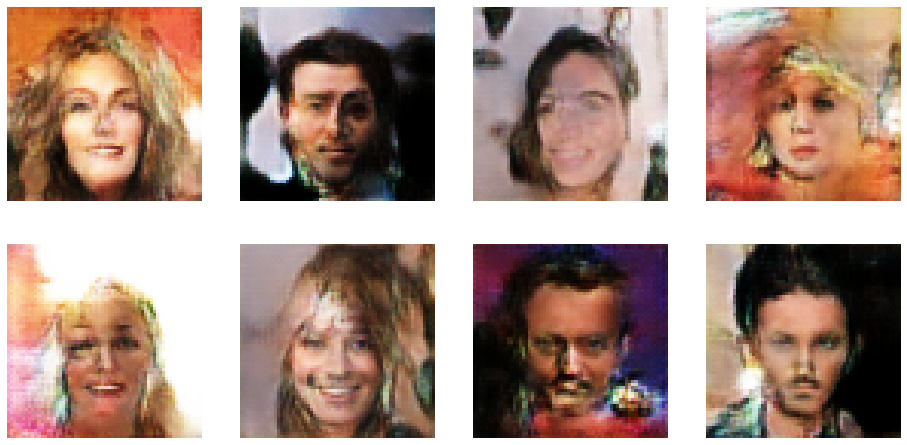

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1d_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1e: lr=2e-4, betas=(0.5,0.999), 1 disc/gen iterations

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func=partial(optim.Adam, betas = (0.5,0.999)), wd=0., 
                           switcher=partial(FixedGANSwitcher, n_crit=1, n_gen=1))

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1e_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1e_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1e_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1e_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

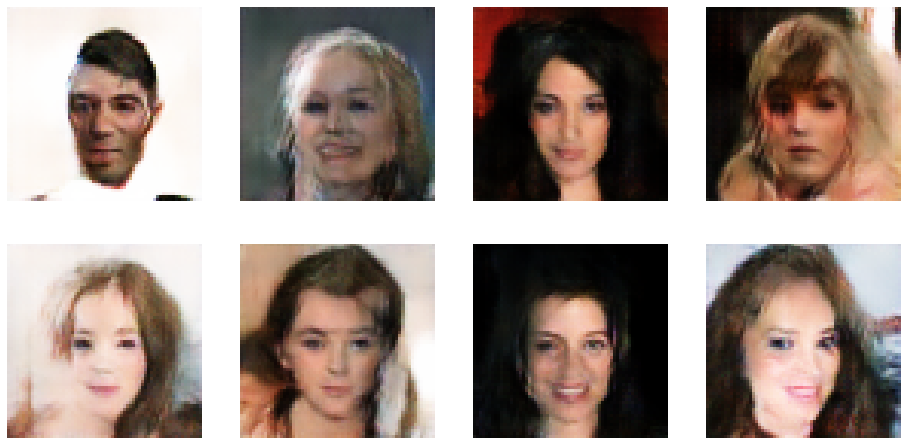

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1e_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1f: lr=2e-4, betas=(0.5,0.999), 2 disc/gen iterations

Not worth it; already proven quite poor with other dataset

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func=partial(optim.Adam, betas = (0.5,0.999)), wd=0., 
                           switcher=partial(FixedGANSwitcher, n_crit=2, n_gen=1))

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1f_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1f_10ep.pth')

#### TR 1g: lr=2e-4, betas=(0,0.999)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                           opt_func=partial(optim.Adam, betas = (0.,0.999)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1g_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1g_10ep.pth')

In [0]:
learner.fit(2, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1g_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1g_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

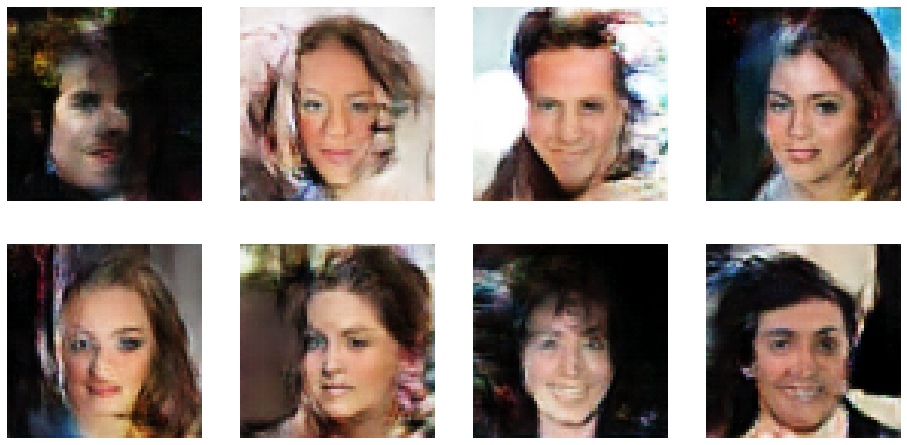

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1g_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1h: lr=2e-4, hinge loss. Critic tries D(real)>=1, D(fake)<=-1. Gen tries D(fake)=inf.

**Hinge loss**

For real images, we want to minimize (real part of critic loss func): $-min(0, -1 + D(x))$
<br>$= max(0, 1-D(x))$

For fake images, we want to minimize (fake part of critic loss func): $-min(0, -1 - D(G(z)))$
<br>$= max(0, 1+D(G(z)))$

In [0]:
hlosses = hinge_adversarial_losses()

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1h_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1h_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1h_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1h_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

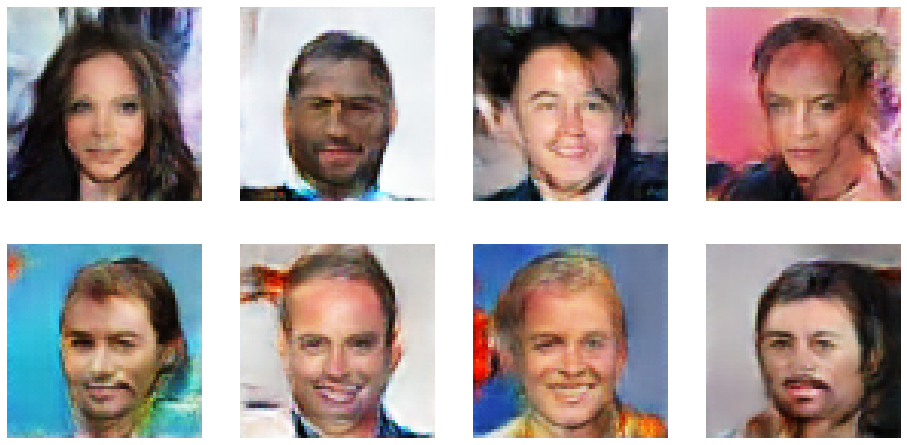

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1h_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1i: lr=2e-4, pseudo hinge loss, only for fake preds. Critic tries D(real)=inf, D(fake)<=-1. Gen tries D(fake)=inf.

Not worth it. Already proven quite poor with other dataset

In [0]:
hlosses = hinge_like_adversarial_losses(math.inf, math.inf, -1.) 

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1i_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1i_10ep.pth')

#### TR 1j: lr=2e-4, hinge loss with margin also in G loss. Critic tries D(real)>=1, D(fake)<=-1. Gen tries D(fake)>=1.

It shouldn't work, I believe the generator needs to push more, although it's the most symmetric formulation.

In [0]:
hlosses = hinge_like_adversarial_losses(1., 1., -1.)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1j_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1j_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1j_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1j_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

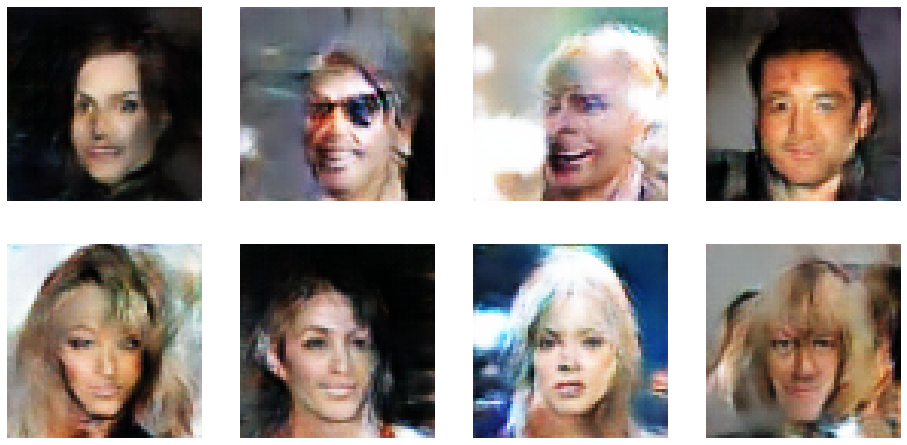

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1j_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1k: lr=2e-4, hinge loss with irregular margin, real identification pushes more in critic. Critic tries D(real)>=10, D(fake)<=-1. Gen tries D(fake)=inf.

Maybe only the difference between the margins minds.

In [0]:
hlosses = hinge_like_adversarial_losses(math.inf, 10., -1.)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1k_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1k_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1k_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1k_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

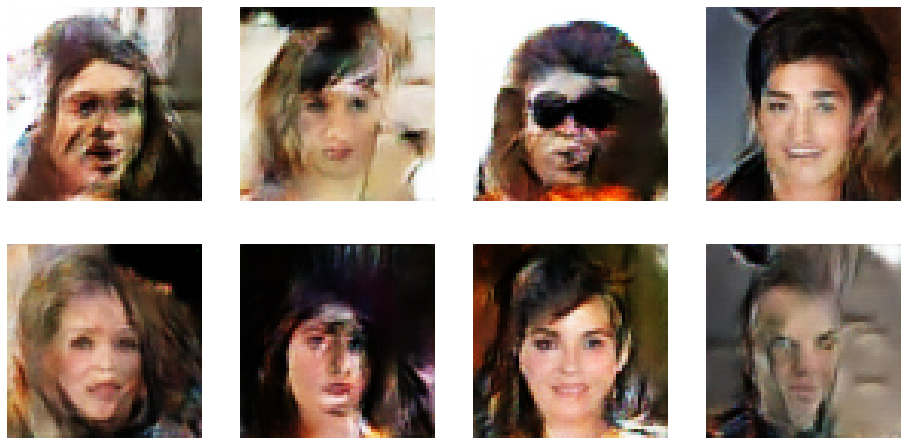

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1k_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1L: lr=2e-4, hinge loss with irregular margin, fake identification pushes more in critic. Critic tries D(real)>=1, D(fake)<=-10, gen tries D(fake)=inf

Maybe only the difference between the margins minds here.

In [0]:
hlosses = hinge_like_adversarial_losses(math.inf, 1., -10.)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1l_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1l_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1l_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1l_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

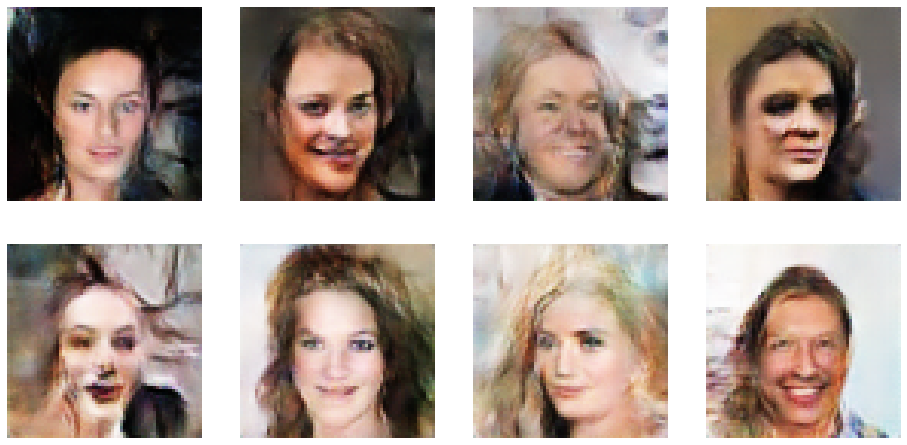

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1l_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TMP TR 1m: lr=2e-4, hinge loss with irregular margin, fake identification pushes more in critic. Critic tries D(real)>=1, D(fake)<=-10. Gen tries D(fake)>=1

In [0]:
hlosses = hinge_like_adversarial_losses(1., 1., -10.) 

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1m_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1m_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1m_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1m_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

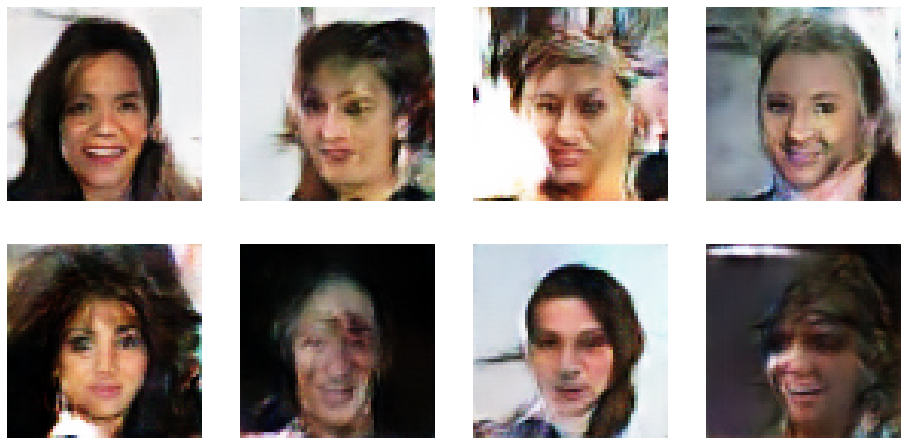

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1m_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TMP TR 1n: lr=2e-4, hinge loss with irregular margin, fake identification pushes more in critic. Critic tries D(real)>=1, D(fake)<=-10. Gen tries D(fake) >= 12

In [0]:
hlosses = hinge_like_adversarial_losses(12., 1., -10.)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1n_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1n_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1n_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1n_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

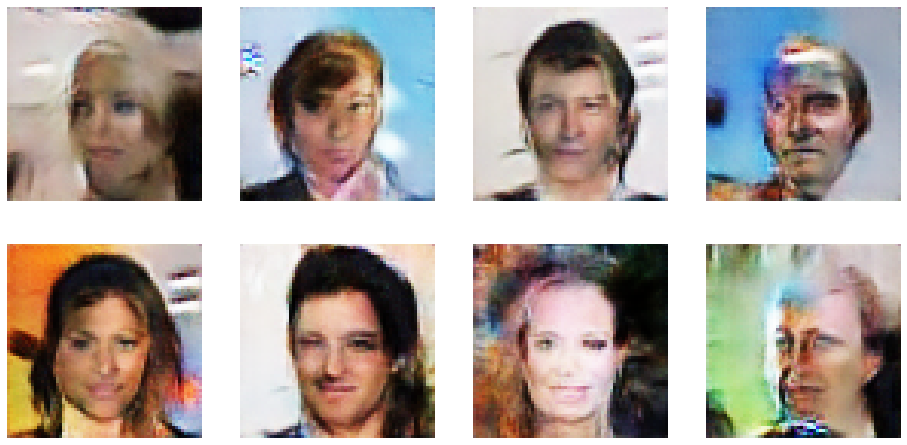

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1n_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1o: lr=2e-4, only hinge loss for real preds. Critic tries D(real)>=1, D(fake)=-inf. Gen tries D(fake)=inf

Not worth it. Already proven quite bad with other dataset.

In [0]:
hlosses = hinge_like_adversarial_losses(math.inf, 1., -math.inf)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1o_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1o_10ep.pth')

#### TR 1p: lr=2e-4, only hinge loss for real preds (1o with log(fake_pred) in critic loss). Critic tries D(real)>=1, D(fake)=-inf slow below 0 (minus sqrt). Gen tries D(fake)=inf

In [0]:
[(x,-(abs(x)**(1/2))) for x in range(-10,10)]

In [0]:
def hinge_adversarial_losses_p(margin:float=1.):
    def _loss_G(fake_pred, output, target):
        return -(fake_pred.mean())

    def _loss_C(real_pred, fake_pred):
        zero = torch.tensor([0.], device=real_pred.device)
        fake_pred_mean = fake_pred.mean()
        return (torch.max(zero, margin - real_pred).mean() + 
               torch.max(fake_pred_mean, -(torch.abs(fake_pred_mean)**(1/2))))

    return _loss_G, _loss_C

hlosses = hinge_adversarial_losses_p()

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1p_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1p_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1p_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1p_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

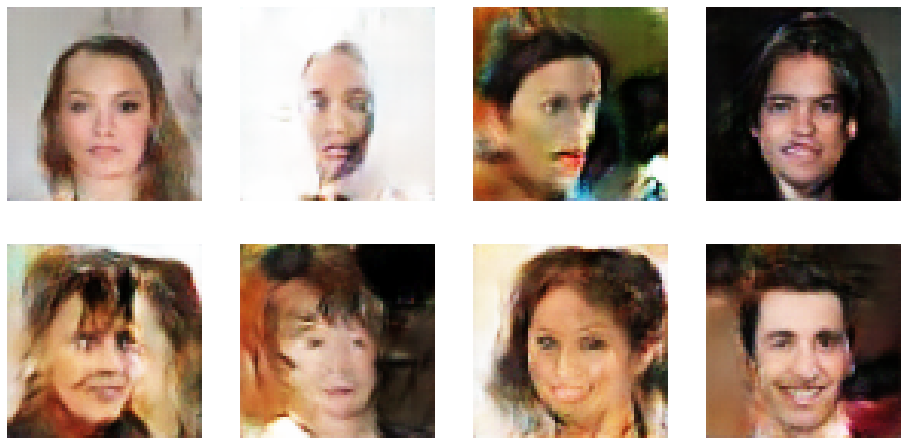

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1p_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1q: *(1j with crit/gen iters = 1/1)* lr=2e-4, hinge loss with margin also in G loss, 1 crit/gen iterations. Critic tries D(real)>=1, D(fake)<=-1. Gen tries D(fake)>=1.

In [0]:
hlosses = hinge_like_adversarial_losses(1., 1., -1.)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.,
                           switcher=partial(FixedGANSwitcher, n_crit=1, n_gen=1))

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1q_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1q_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1q_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1q_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

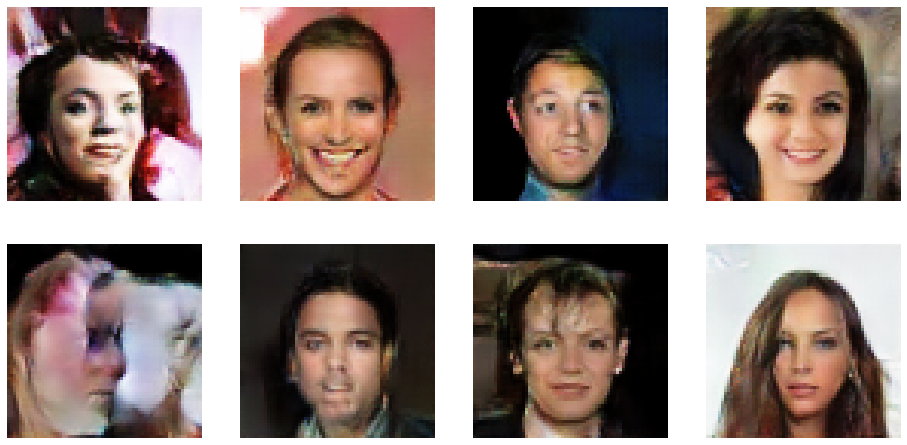

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1q_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

#### TR 1r: (1h with crit/gen iters = 1/1) lr=2e-4, hinge loss. Critic tries D(real)>=1, D(fake)<=-1. Gen tries D(fake)=inf.

In [0]:
hlosses = hinge_adversarial_losses()

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*hlosses), switch_eval=False, 
                           opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.,
                           switcher=partial(FixedGANSwitcher, n_crit=1, n_gen=1))

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1r_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1r_10ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1r_15ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr1r_20ep.pth')

In [0]:
learner.show_results(ds_type=DatasetType.Train)

---
Showing results after returning to work...

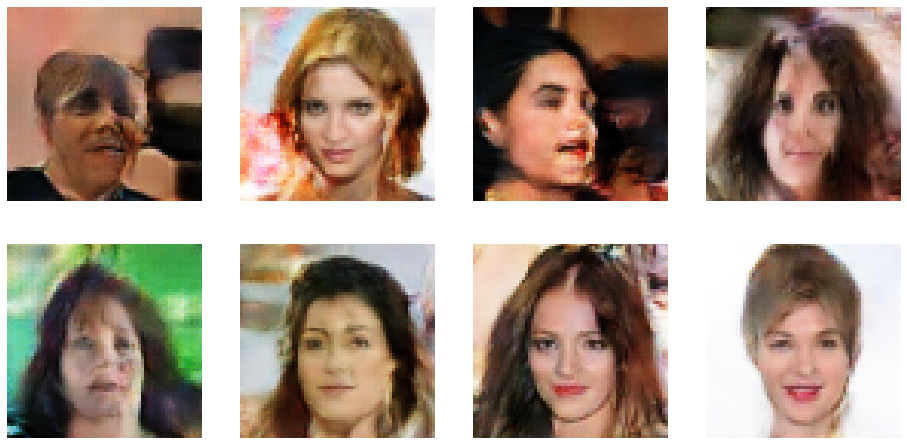

In [0]:
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
load_gan_generator(generator, models_root + 'sngan-dcgan-celeba-tr1r_20ep.pth')
display_gan_out_tensor(GenImagesSampler(generator).get(8))

### TR 2: Spectral norm in critic and generator

This doesn't work. After a few epochs and it doesn't generate anything meaningful.

#### TR 2a: lr=2e-4

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                     opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.769051,#na#,5.408693,0.079725,09:31
1,0.902897,#na#,4.999683,0.118613,09:20
2,1.338840,#na#,7.538707,0.000398,09:18
3,1.645806,#na#,10.078779,0.068618,09:14
4,1.205679,#na#,6.539599,0.145924,09:19


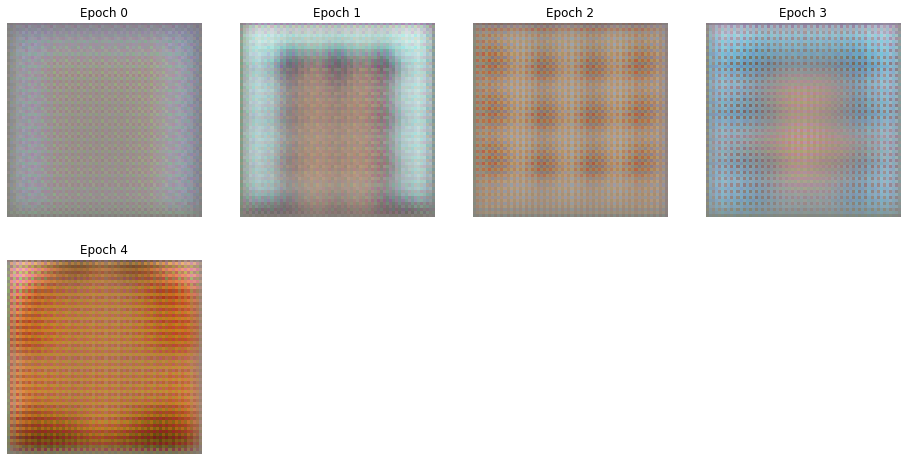

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr2a_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr2a_10ep.pth')

#### TR 2b: lr=5e-4

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
learner = CustomGANLearner(data, generator, critic, GANLossArgs(*losses), switch_eval=False, 
                     opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,1.297431,#na#,6.950902,0.004812,09:21
1,1.080430,#na#,6.034043,0.004600,09:19
2,0.954488,#na#,6.860210,0.032328,09:20
3,1.144041,#na#,6.607107,0.005071,09:04
4,0.698752,#na#,6.861554,0.191660,09:06


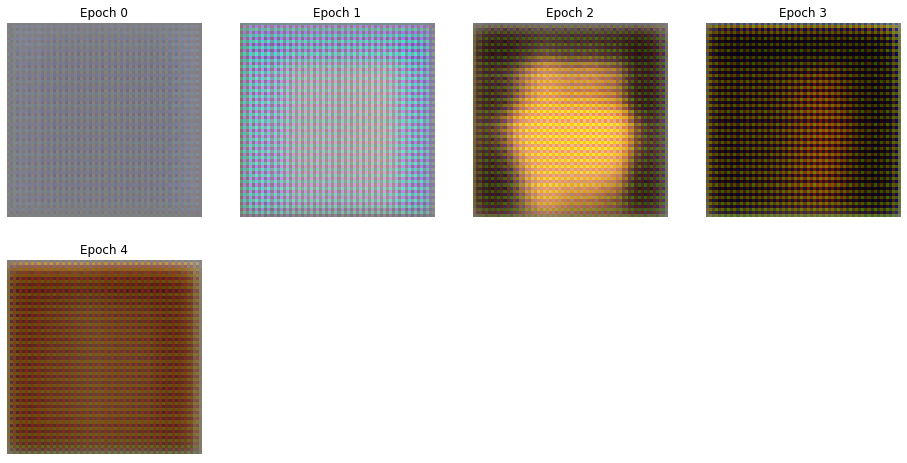

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr2b_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-dcgan-celeba-tr2b_10ep.pth')

## WGAN

It doesn't work. After a few epochs it only generates some blurs, the learning process is much slower

### TR 1: Spectral norm only in critic, batch norm in generator

#### TR 1a: lr=2e-4

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                          opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,84.559464,#na#,2476.636230,-1008.551086,09:33
1,-15.417290,#na#,1540.918213,-1065.475830,09:30
2,-825.641357,#na#,402.216675,-1494.349243,09:23
3,337.852539,#na#,1229.085205,-1674.584961,09:14
4,-84.127518,#na#,-2746.666016,-1928.090210,09:05


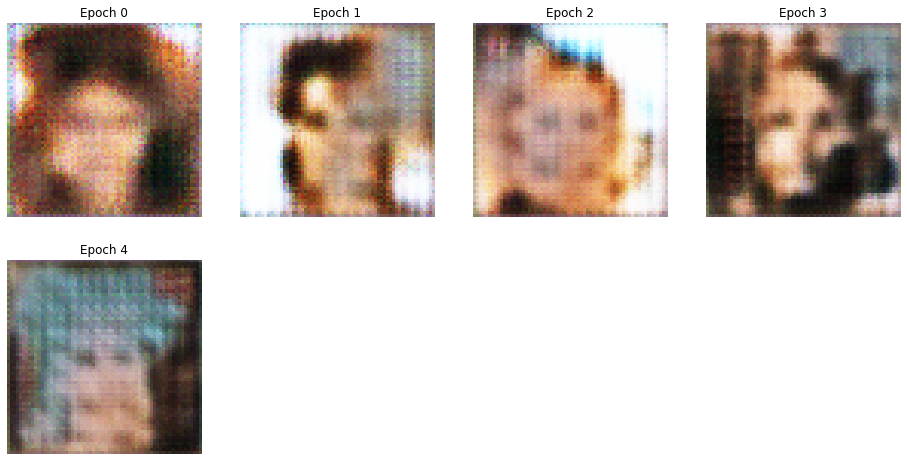

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1a_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1a_10ep.pth')

#### TR 1b: lr=5e-4

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-1409.950195,#na#,995.002747,-1172.179932,09:07
1,-351.184814,#na#,-3433.565674,-930.647705,08:58
2,-1799.233032,#na#,-12131.348633,-1017.421631,08:56
3,-6791.473633,#na#,-26062.414062,-1529.366089,09:00
4,-7671.342285,#na#,-39269.375000,-1602.318481,08:55


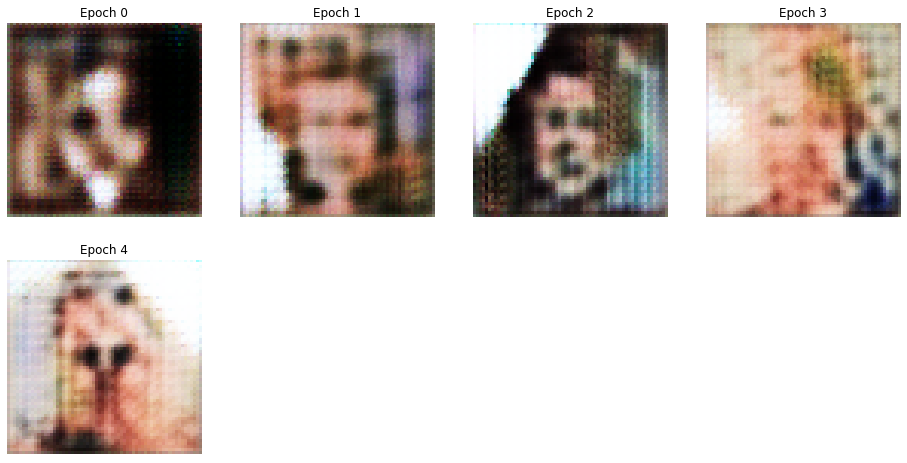

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1b_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1b_10ep.pth')

#### TR 1c: lr=2e-4, betas=(0.5,0.9)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.5,0.9)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1c_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1c_10ep.pth')

#### TR 1d: lr=2e-4, betas=(0.5,0.999)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.5,0.999)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1d_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1d_10ep.pth')

#### TR 1e: lr=2e-4, betas=(0,0.999)

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.999)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1e_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr1e_10ep.pth')

### TR 2: Spectral norm in critic and generator

#### TR 2a: lr=2e-4

In [0]:
lr = 2e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                          opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr2a_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr2a_10ep.pth')

#### TR 2b: lr=5e-4

In [0]:
lr = 5e-4
critic = custom_critic(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
generator = basic_generator(img_size, img_n_channels, n_extra_layers=1, norm_type=NormType.Spectral)
learner = CustomGANLearner.wgan(data, generator, critic, clip=None, switch_eval=False, 
                                opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-1126061.125000,#na#,-2403.026367,-1298917.250000,09:35


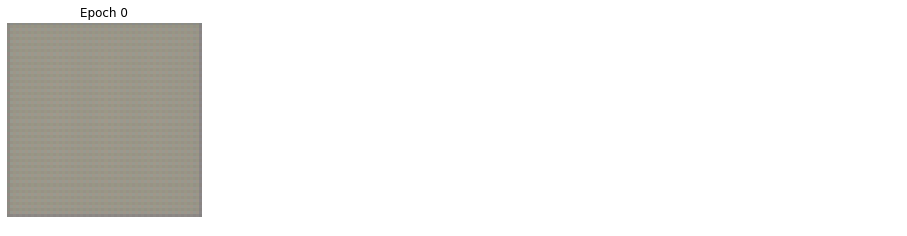

KeyboardInterrupt: 

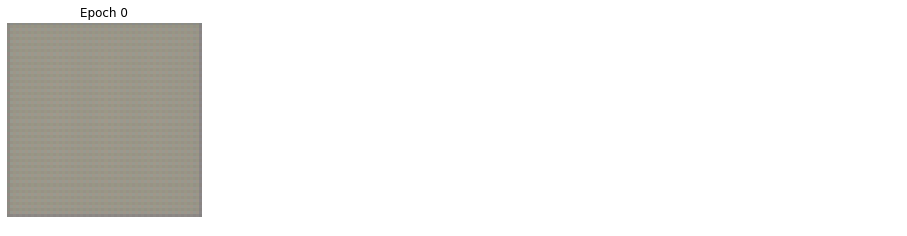

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr2b_5ep.pth')

In [0]:
learner.fit(5, lr)
save_gan_learner(learner, models_root + 'sngan-wgan-celeba-tr2b_10ep.pth')

# RESULTS EVALUATION

In [14]:
calculator = FIDCalculator()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [13]:
model_ids = ['1' + chr(ord('a') + i) for i in range(ord('r') + 1 - ord('a'))]
model_ids = [m for m in model_ids if m not in ('1c', '1f', '1i', '1o')]
model_ids

['1a',
 '1b',
 '1d',
 '1e',
 '1g',
 '1h',
 '1j',
 '1k',
 '1l',
 '1m',
 '1n',
 '1p',
 '1q',
 '1r']

In [19]:
n_total_imgs = 10000
n_imgs_by_group = 500

models = [EvaluationItem(model_id, basic_generator, [img_size, img_n_channels], {'n_extra_layers': 1})
          for model_id in model_ids]

def resolve_state_path(model_id:str):
    return f'{models_root}sngan-dcgan-celeba-tr{model_id}_20ep.pth'

results = evaluate_models_fid(models, data, GeneratorFuncStateLoader(resolve_state_path),
                              n_total_imgs, n_imgs_by_group, calculator, PrinterProgressTracker())

Completed model 1a with FID=54.82244873046875, std=1.5300920009613037
Completed model 1b with FID=48.266326904296875, std=1.7430016994476318
Completed model 1d with FID=63.239532470703125, std=1.2898072004318237
Completed model 1e with FID=53.08692932128906, std=1.836695671081543
Completed model 1g with FID=59.4272346496582, std=1.766631841659546
Completed model 1h with FID=54.74273681640625, std=1.6256247758865356
Completed model 1j with FID=57.52117919921875, std=1.6263960599899292
Completed model 1k with FID=56.996585845947266, std=1.4469045400619507
Completed model 1l with FID=58.61577224731445, std=1.450385332107544
Completed model 1m with FID=58.26272964477539, std=1.386592984199524
Completed model 1n with FID=65.5932388305664, std=1.7566492557525635
Completed model 1p with FID=55.03314208984375, std=1.2021026611328125
Completed model 1q with FID=42.708953857421875, std=1.3757137060165405
Completed model 1r with FID=43.48661422729492, std=0.9057746529579163


* Completed model 1a with FID=54.82244873046875, std=1.5300920009613037
* Completed model 1b with FID=48.266326904296875, std=1.7430016994476318
* Completed model 1d with FID=63.239532470703125, std=1.2898072004318237
* Completed model 1e with FID=53.08692932128906, std=1.836695671081543
* Completed model 1g with FID=59.4272346496582, std=1.766631841659546
* Completed model 1h with FID=54.74273681640625, std=1.6256247758865356
* Completed model 1j with FID=57.52117919921875, std=1.6263960599899292
* Completed model 1k with FID=56.996585845947266, std=1.4469045400619507
* Completed model 1l with FID=58.61577224731445, std=1.450385332107544
* Completed model 1m with FID=58.26272964477539, std=1.386592984199524
* Completed model 1n with FID=65.5932388305664, std=1.7566492557525635
* Completed model 1p with FID=55.03314208984375, std=1.2021026611328125
* Completed model 1q with FID=**42.708953857421875**, std=1.3757137060165405
* Completed model 1r with FID=43.48661422729492, std=0.9057746529579163

In [20]:
results

{'1a': EvaluationResult(mean=54.82244873046875, stdev=1.5300920009613037),
 '1b': EvaluationResult(mean=48.266326904296875, stdev=1.7430016994476318),
 '1d': EvaluationResult(mean=63.239532470703125, stdev=1.2898072004318237),
 '1e': EvaluationResult(mean=53.08692932128906, stdev=1.836695671081543),
 '1g': EvaluationResult(mean=59.4272346496582, stdev=1.766631841659546),
 '1h': EvaluationResult(mean=54.74273681640625, stdev=1.6256247758865356),
 '1j': EvaluationResult(mean=57.52117919921875, stdev=1.6263960599899292),
 '1k': EvaluationResult(mean=56.996585845947266, stdev=1.4469045400619507),
 '1l': EvaluationResult(mean=58.61577224731445, stdev=1.450385332107544),
 '1m': EvaluationResult(mean=58.26272964477539, stdev=1.386592984199524),
 '1n': EvaluationResult(mean=65.5932388305664, stdev=1.7566492557525635),
 '1p': EvaluationResult(mean=55.03314208984375, stdev=1.2021026611328125),
 '1q': EvaluationResult(mean=42.708953857421875, stdev=1.3757137060165405),
 '1r': EvaluationResult(mea

# PENDING AND FINDINGS

Pending:
* Look into how to make spectral norm work in generator.

Facts:

* betas=(0.9,0.999), 1 disc/gen iterations doesn't work, at least with DCGAN. It's not common to see big beta1 values having a positive impact in GANs.
* WGAN (without GP) is difficult to tweak, and isn't even considered in the paper.

